In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect = True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.

# Measurement table recent date query
recent_date_query = session.query(func.max(Measurement.date)).all()
max_date = recent_date_query[0][0]
print(f"Most recent date in Measurement table: {max_date}")

# Measurement table count query
measurement_table = session.query(Measurement.date).count()
measurement_table_date = session.query(Measurement).filter(Measurement.date == max_date).count()
print(f"Count of recent date in Measurement table: {measurement_table_date}")

Most recent date in Measurement table: 2017-08-23
Count of recent date in Measurement table: 4


In [10]:
# Station table first row query
first_row_table2 = session.query(Station).first()
print(f"""First row print of Station table information:
{first_row_table2.__dict__}\n""")

for key, value in first_row_table2.__dict__.items():
    print(f"{key}: {value}")

# station_query = session.query(Station)

First row print of Station table information:
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x7fc0c0c92280>, 'longitude': -157.8168, 'name': 'WAIKIKI 717.2, HI US', 'id': 1, 'elevation': 3.0, 'station': 'USC00519397', 'latitude': 21.2716}

_sa_instance_state: <sqlalchemy.orm.state.InstanceState object at 0x7fc0c0c92280>
longitude: -157.8168
name: WAIKIKI 717.2, HI US
id: 1
elevation: 3.0
station: USC00519397
latitude: 21.2716


In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
max_date_list = max_date.split("-")
starting_date = dt.date(int(max_date_list[0]), int(max_date_list[1]), int(max_date_list[2]))
print(starting_date)

one_year = dt.timedelta(days = 366)

time1 = starting_date - one_year
print(time1)

2017-08-23
2016-08-22


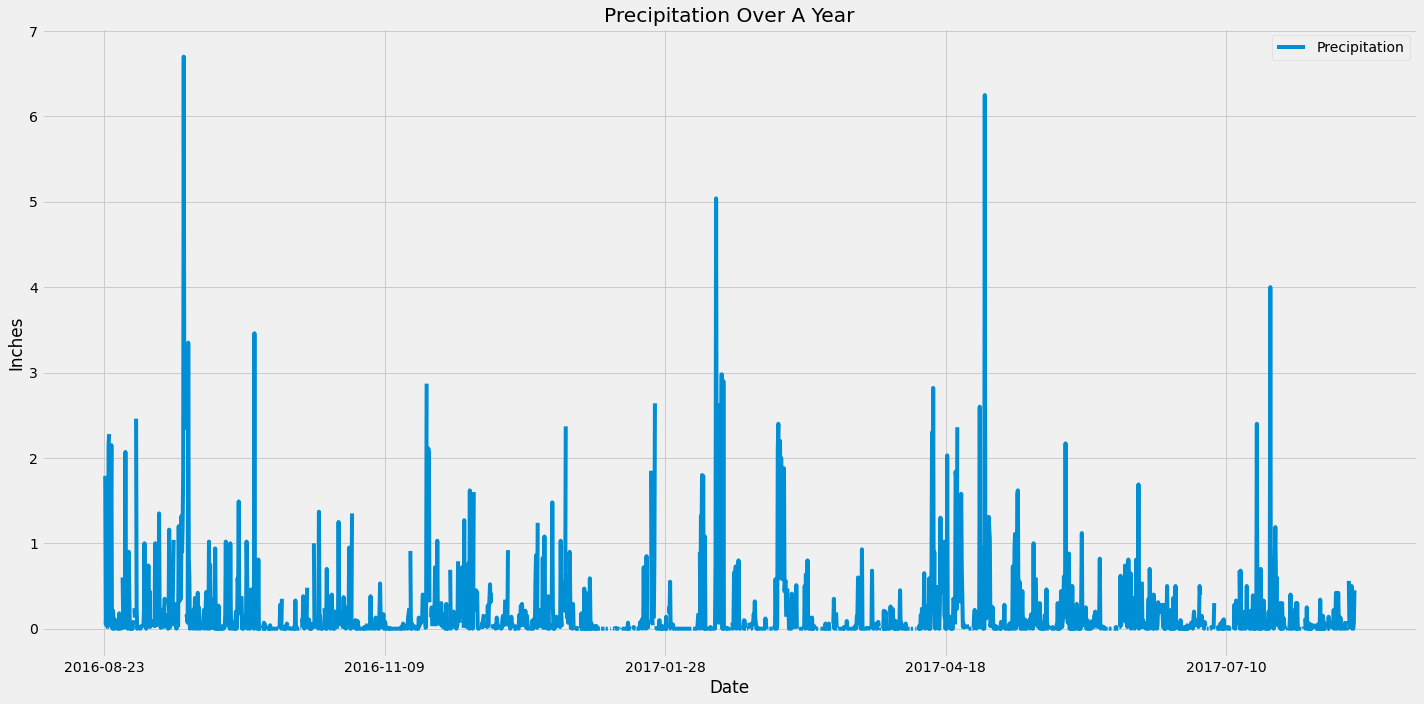

In [17]:
# Perform a query to retrieve the data and precipitation scores
prcp_date_2 = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > (time1)).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
result_df = pd.DataFrame(data = prcp_date_2, columns = ["Date", "Precipitation"])
result_df2 = result_df.set_index("Date")

# Sort the dataframe by date
result_df3 = result_df2.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
result_df3.plot.line(figsize = (20, 10))
plt.xlabel("Date")
plt.ylabel("Inches")
plt.title("Precipitation Over A Year")
plt.tight_layout()

In [18]:
# Use Pandas to calculate the summary statistics for the precipitation data
result_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [19]:
# Design a query to calculate the total number stations in the dataset
sql_query = f"SELECT count(station) FROM Measurement"

station_ct1 = session.execute(sql_query).fetchall()
print(station_ct1)

station_ct2 = session.query(Measurement.station)
print(station_ct2.count())

station_ct3 = session.query(Station.station)
print(station_ct3.all())


[(19550,)]
19550
[('USC00519397',), ('USC00513117',), ('USC00514830',), ('USC00517948',), ('USC00518838',), ('USC00519523',), ('USC00519281',), ('USC00511918',), ('USC00516128',)]


In [20]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
from sqlalchemy import distinct, desc

distinct_station_ct = session.query(Measurement.station, func.count(Measurement.station).label("Station Activity")).group_by(Measurement.station)
sorted_station_list = distinct_station_ct.order_by(desc("Station Activity")).all()

for count_per_station in sorted_station_list:
    print(count_per_station)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [21]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temp_calc_min = session.query(func.min(Measurement.tobs)).filter(Measurement.station == sorted_station_list[0][0]).scalar()
print("Min temp: ", temp_calc_min)

temp_calc_max = session.query(func.max(Measurement.tobs)).filter(Measurement.station == sorted_station_list[0][0]).scalar()
print("Max temp: ", temp_calc_max)

temp_calc_avg = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == sorted_station_list[0][0]).scalar()
print("Avg temp: ", temp_calc_avg)

Min temp:  54.0
Max temp:  85.0
Avg temp:  71.66378066378067


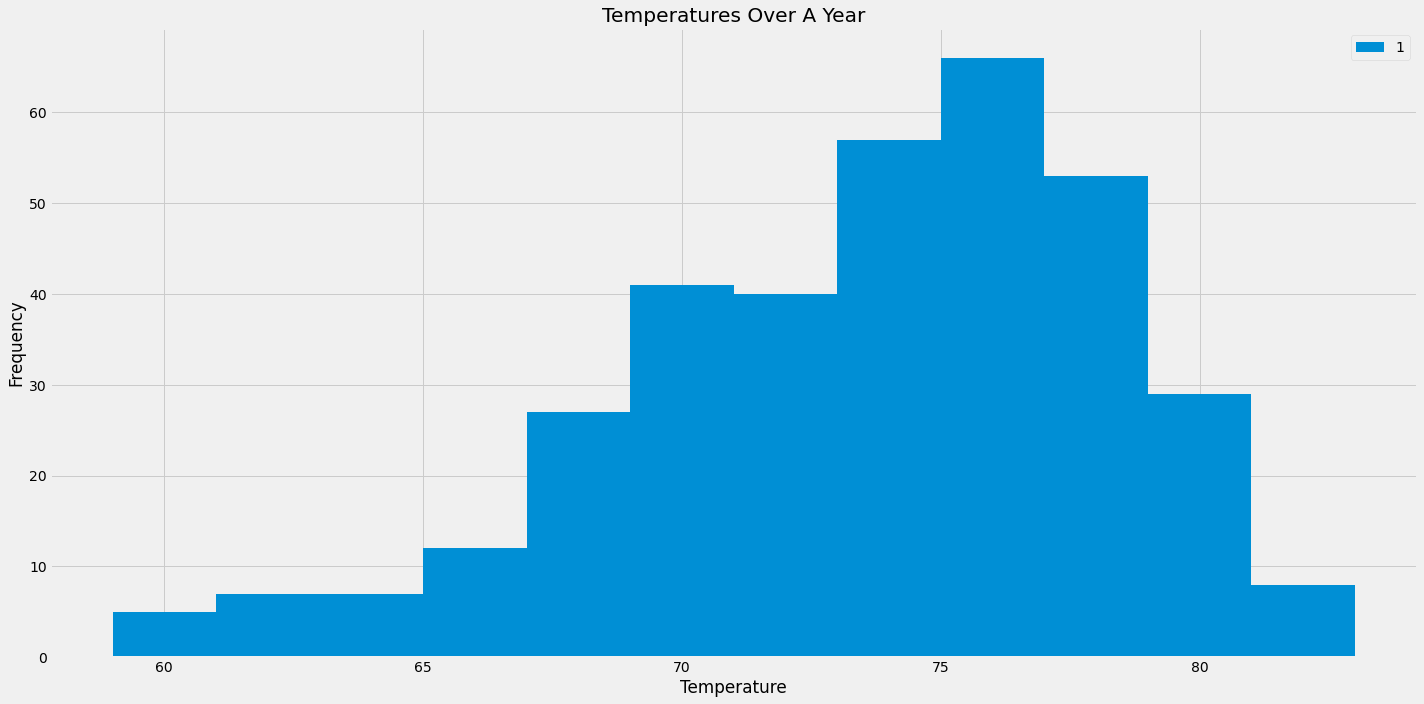

In [37]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_year = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date > time1, Measurement.station == sorted_station_list[0][0]).all()

temp_year_df = pd.DataFrame(temp_year)

temp_year_df.plot.hist(bins = 12, figsize = (20, 10))
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title("Temperatures Over A Year")
plt.tight_layout()

# Close session

In [ ]:
# Close Session
session.close()